# 1. Text Classification

## 3.1 Text Preprocessing, Tokenization, and Sequence Padding:

### 3.1.1 Load the dataset:

In [ ]:
# Install required packages
!pip install contractions
!pip install gensim
!pip install wordcloud
!pip install gradio
!pip install imblearn

In [ ]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import re
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import gradio as gr
import gensim.downloader as api
from imblearn.over_sampling import RandomOverSampler

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Load the dataset
hotel_data = pd.read_csv('/content/drive/MyDrive/Task_2_AI_Final/Hotel_Reviews.csv')

# Display dataset overview

In [ ]:
# Display dataset overview
print(f"Dataset dimensions: {hotel_data.shape}")
print("\nFirst few rows:")
display(hotel_data.head())

Dataset dimensions: (20491, 2)

First few rows:


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
np.sort(hotel_data['Rating'].unique())

array([1, 2, 3, 4, 5])

In [ ]:
# Check column data types
hotel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
# Rating distribution
rating_frequencies = hotel_data['Rating'].value_counts()

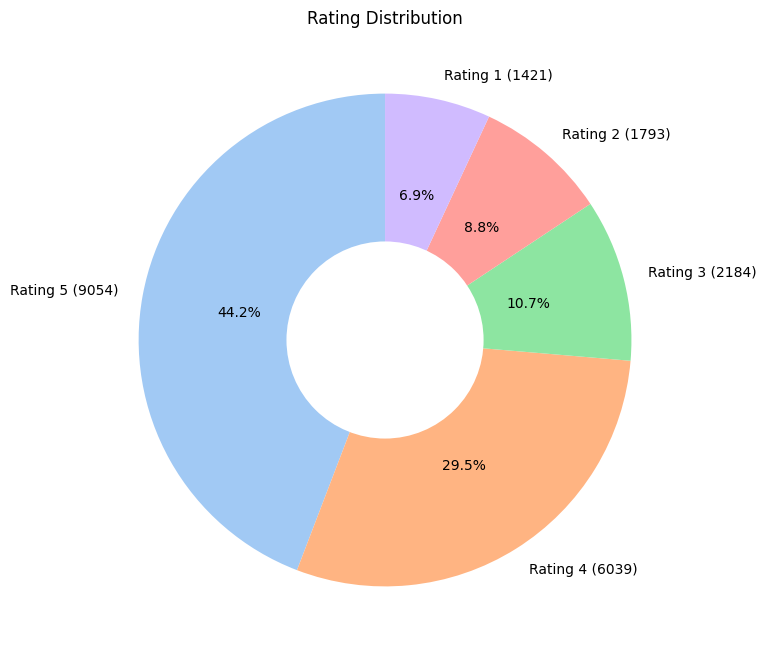

In [ ]:
# Create a donut chart instead of pie chart
plt.figure(figsize=(8, 8))
plt.pie(rating_frequencies, labels=[f"Rating {label} ({count})" for label, count in zip(rating_frequencies.index, rating_frequencies)],
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.gca().add_artist(plt.Circle((0,0),0.4,fc='white'))  # Donut hole
plt.title("Rating Distribution")
plt.savefig('rating_donut.png')
plt.show()

In [ ]:
# Check for missing values
hotel_data.isna().sum()

,0
Review,0
Rating,0


In [ ]:
# Calculate review length
hotel_data['review_length'] = hotel_data['Review'].apply(len)
hotel_data.head()

,Review,Rating,review_length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


In [ ]:
# Maximum review length
max_review_length = hotel_data['Review'].str.len().max()
print(f"Maximum review text length: {max_review_length}")

Maximum review text length: 13501


In [ ]:
# Check for duplicates
hotel_data.duplicated().sum()

0

### 3.2 Data pre processing

In [ ]:
# Initialize text processing tools
word_lemmatizer = WordNetLemmatizer()
english_stopwords = set(stopwords.words('english'))

In [ ]:
def clean_review_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|\#\w+', '', text)

    # Remove numbers and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Expand contractions
    text = contractions.fix(text)

    # Lemmatize and remove stopwords, keep sentiment words
    tokens = text.split()
    sentiment_words = {'not', 'very', 'really', 'quite', 'too', 'so', 'bad', 'poor', 'great', 'good', 'never', 'terrible', 'excellent', 'horrible', 'awful'}
    tokens = [word_lemmatizer.lemmatize(word) for word in tokens if word not in english_stopwords or word in sentiment_words]
    return ' '.join(tokens)

In [ ]:
# Apply text cleaning
hotel_data['processed_review'] = hotel_data['Review'].apply(clean_review_text)

In [ ]:
# Check for empty processed reviews
print("\nEmpty processed reviews:", sum(hotel_data['processed_review'] == ''))


Empty processed reviews: 0


Creating word cloud for processed reviews...


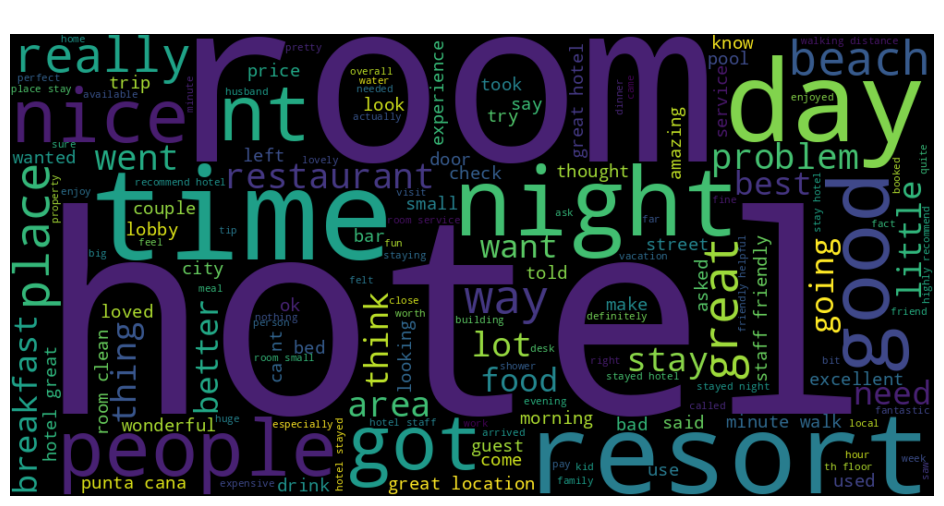

In [ ]:
# Generate word cloud
print("Creating word cloud for processed reviews...")
combined_text = ' '.join(hotel_data['processed_review'])
wc = WordCloud(width=1000, height=500, background_color='black', max_words=150, colormap='viridis', random_state=42).generate(combined_text)
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Processed Hotel Reviews', fontsize=16, color='white')
plt.savefig('word_cloud_reviews.png')
plt.show()

Plotting most common words...


<ipython-input-19-7e904763dd7f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq_list, y=word_list, palette='magma')


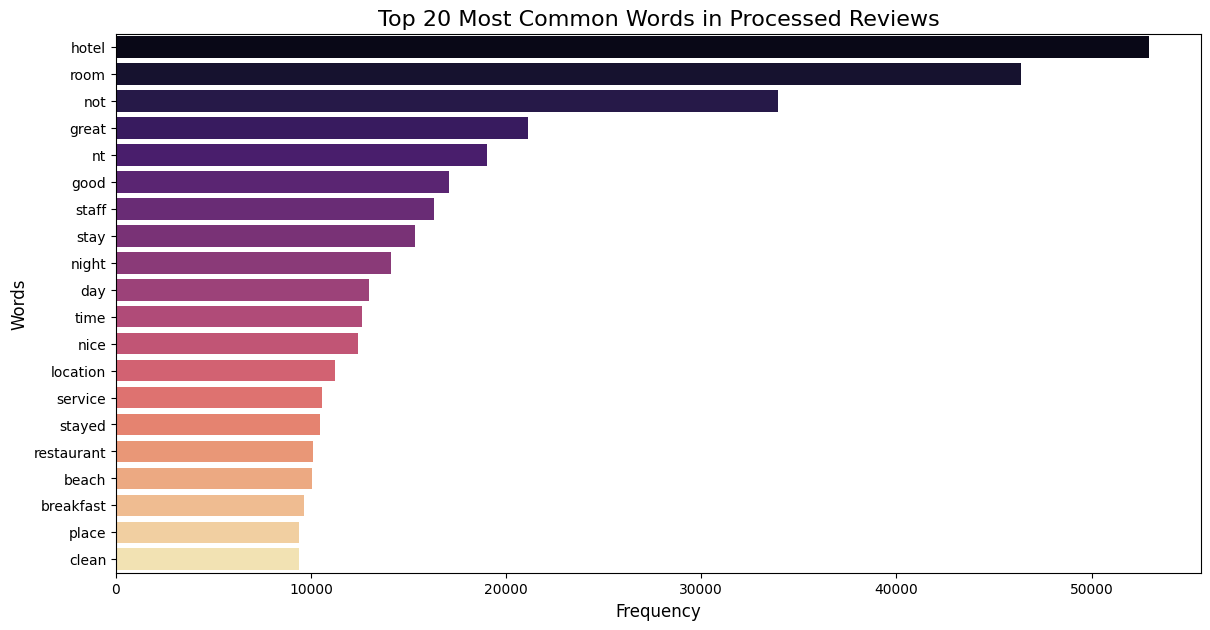

In [ ]:
# Plot frequent words
print("Plotting most common words...")
all_words = combined_text.split()
word_frequencies = Counter(all_words)
top_words = word_frequencies.most_common(20)
word_list, freq_list = zip(*top_words)
plt.figure(figsize=(14, 7))
sns.barplot(x=freq_list, y=word_list, palette='magma')
plt.title('Top 20 Most Common Words in Processed Reviews', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.savefig('common_words.png')
plt.show()

In [ ]:
# Split data
features = hotel_data['processed_review']
labels = hotel_data['Rating'] - 1  # Shift ratings to 0-4
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

In [ ]:
# Oversample minority classes
oversampler = RandomOverSampler(sampling_strategy={0: 4000, 1: 4000, 2: 4000}, random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train_data.to_frame(), y_train_data)
X_train_oversampled = X_train_oversampled['processed_review']

In [ ]:
# Check new distribution
print("\nTraining Data Distribution After Oversampling:")
print(pd.Series(y_train_oversampled).value_counts())


Training Data Distribution After Oversampling:
Rating
4    7243
3    4831
1    4000
2    4000
0    4000
Name: count, dtype: int64


In [ ]:
# Tokenize text
text_tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
text_tokenizer.fit_on_texts(X_train_oversampled)

# Convert to sequences
train_sequences = text_tokenizer.texts_to_sequences(X_train_oversampled)
test_sequences = text_tokenizer.texts_to_sequences(X_test_data)

# Calculate padding length
sequence_lengths = [len(seq) for seq in train_sequences]
padding_length = int(np.percentile(sequence_lengths, 95))
print(f"Padding sequence length: {padding_length} (95th percentile)")

# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=padding_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=padding_length, padding='post', truncating='post')

Padding sequence length: 274 (95th percentile)


In [ ]:
# One-hot encode labels
num_rating_classes = 5
train_labels_encoded = tf.keras.utils.to_categorical(y_train_oversampled, num_rating_classes)
test_labels_encoded = tf.keras.utils.to_categorical(y_test_data, num_rating_classes)

In [ ]:
# Load Word2Vec embeddings
print("Loading pretrained Word2Vec embeddings...")
word2vec_model = api.load('word2vec-google-news-300')
embedding_size = 300

Loading pretrained Word2Vec embeddings...
[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Compute class weights
class_weights_balanced = compute_class_weight('balanced', classes=np.unique(y_train_data), y=y_train_data)
class_weights_dict = dict(enumerate(class_weights_balanced))
class_weights_dict[0] *= 0.8  # Adjust for rating 1
class_weights_dict[1] *= 0.8  # Adjust for rating 2
class_weights_dict[2] *= 0.8  # Adjust for rating 3
print("\nAdjusted Class Weights:", class_weights_dict)


Adjusted Class Weights: {0: 2.3067018469656992, 1: 1.8289539748953976, 2: 1.5012707498568976, 3: 0.6786172635065204, 4: 0.45263012563854754}


In [ ]:
# Create embedding matrix
vocab_size = len(text_tokenizer.word_index) + 1
embedding_weights = np.zeros((vocab_size, embedding_size))
for word, idx in text_tokenizer.word_index.items():
    if idx < vocab_size and word in word2vec_model:
        embedding_weights[idx] = word2vec_model[word]

In [ ]:
# Define models
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=padding_length),
    Bidirectional(SimpleRNN(32, return_sequences=False, kernel_regularizer=l2(0.01))),
    Dropout(0.5),
    Dense(num_rating_classes, activation='softmax')
])
rnn_model.compile(optimizer=Adam(learning_rate=0.00005, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=padding_length),
    Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01))),
    Dropout(0.5),
    Dense(num_rating_classes, activation='softmax')
])
lstm_model.compile(optimizer=Adam(learning_rate=0.00005, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

word2vec_lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[embedding_weights], input_length=padding_length, trainable=True),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),
    Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01))),
    Dropout(0.5),
    Dense(num_rating_classes, activation='softmax')
])
word2vec_lstm_model.compile(optimizer=Adam(learning_rate=0.00005, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Training function
def train_network(model, X_train, y_train, X_val, y_val, network_name, epochs=20):
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    training_history = model.fit(
        X_train, y_train, epochs=epochs, batch_size=32,
        validation_data=(X_val, y_val), callbacks=[early_stop, lr_reducer], verbose=1
    )

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(training_history.history['accuracy'], label='Training Accuracy', color='purple')
    plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title(f'{network_name} Accuracy Over Epochs', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(training_history.history['loss'], label='Training Loss', color='purple')
    plt.plot(training_history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'{network_name} Loss Over Epochs', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{network_name}_training_metrics.png')
    plt.show()

    return training_history

Training RNN Model...
Epoch 1/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 50s 51ms/step - accuracy: 0.2504 - loss: 2.6597 - val_accuracy: 0.4411 - val_loss: 2.2791 - learning_rate: 5.0000e-05
Epoch 2/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.3832 - loss: 2.2258 - val_accuracy: 0.4428 - val_loss: 2.0122 - learning_rate: 5.0000e-05
Epoch 3/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4869 - loss: 1.9111 - val_accuracy: 0.4438 - val_loss: 1.8467 - learning_rate: 5.0000e-05
Epoch 4/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.5746 - loss: 1.6515 - val_accuracy: 0.5028 - val_loss: 1.6083 - learning_rate: 5.0000e-05
Epoch 5/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.6733 - loss: 1.3357 - val_accuracy: 0.5165 - val_loss: 1.4937 - learning_rate: 5.0000e-05
Epoch 6/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.7315 - loss: 1.1295 - val_accuracy: 0.5113 - val_loss: 1.4382 - learning_rate: 5.0000e-05
Epoch 7/20
753/753 ━━━━━━━━━━━

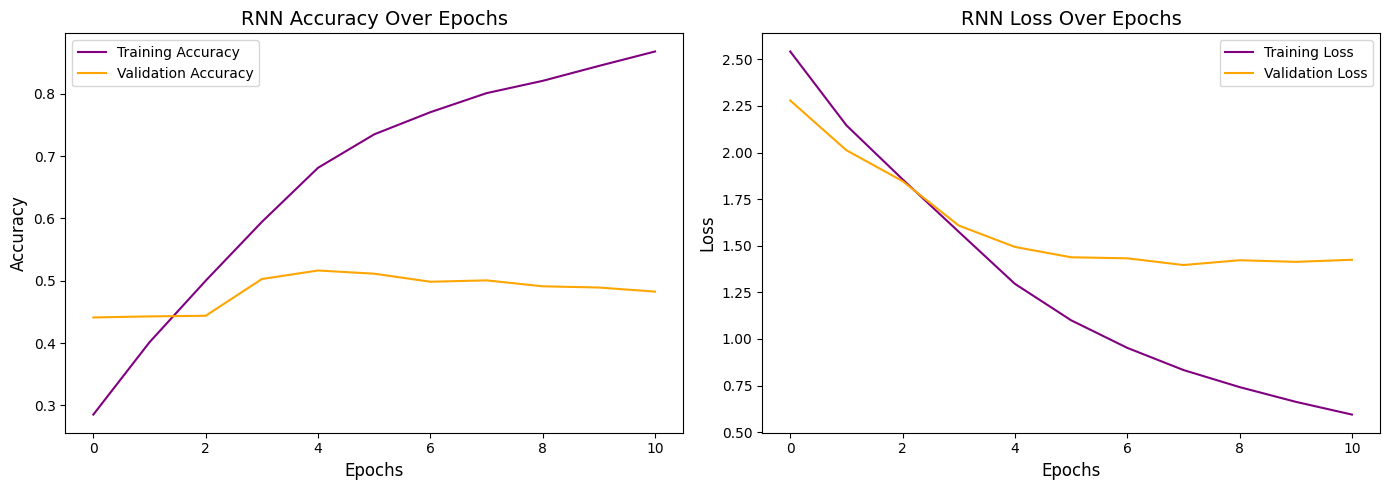

In [ ]:
# Train models
print("Training RNN Model...")
rnn_history = train_network(rnn_model, train_padded, train_labels_encoded, test_padded, test_labels_encoded, "RNN")


Training LSTM Model...
Epoch 1/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.2712 - loss: 4.4768 - val_accuracy: 0.4801 - val_loss: 2.6812 - learning_rate: 5.0000e-05
Epoch 2/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.4324 - loss: 2.4956 - val_accuracy: 0.4970 - val_loss: 1.7198 - learning_rate: 5.0000e-05
Epoch 3/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.4603 - loss: 1.7236 - val_accuracy: 0.5050 - val_loss: 1.3409 - learning_rate: 5.0000e-05
Epoch 4/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.4987 - loss: 1.3573 - val_accuracy: 0.5453 - val_loss: 1.1701 - learning_rate: 5.0000e-05
Epoch 5/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - accuracy: 0.5268 - loss: 1.2001 - val_accuracy: 0.5623 - val_loss: 1.1094 - learning_rate: 5.0000e-05
Epoch 6/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 37s 35ms/step - accuracy: 0.5532 - loss: 1.1187 - val_accuracy: 0.5584 - val_loss: 1.0884 - learning_rate: 5.0000e-05
Epoch 7/20
753/753 ━━━━━━━━━

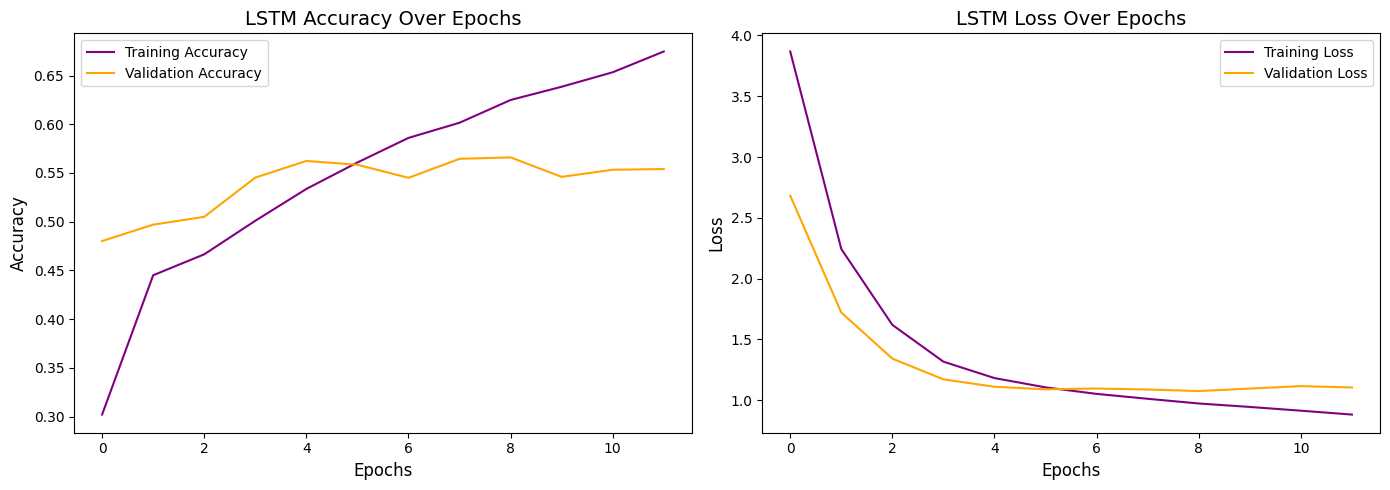

In [ ]:
print("\nTraining LSTM Model...")
lstm_history = train_network(lstm_model, train_padded, train_labels_encoded, test_padded, test_labels_encoded, "LSTM")


Training Word2Vec LSTM Model...
Epoch 1/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.2855 - loss: 8.1029 - val_accuracy: 0.4950 - val_loss: 4.4048 - learning_rate: 5.0000e-05
Epoch 2/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.4834 - loss: 3.8680 - val_accuracy: 0.5782 - val_loss: 2.4182 - learning_rate: 5.0000e-05
Epoch 3/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.5800 - loss: 2.2504 - val_accuracy: 0.5943 - val_loss: 1.6861 - learning_rate: 5.0000e-05
Epoch 4/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.6320 - loss: 1.5857 - val_accuracy: 0.5870 - val_loss: 1.4231 - learning_rate: 5.0000e-05
Epoch 5/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.6713 - loss: 1.2875 - val_accuracy: 0.6075 - val_loss: 1.2674 - learning_rate: 5.0000e-05
Epoch 6/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.7030 - loss: 1.1299 - val_accuracy: 0.5958 - val_loss: 1.2254 - learning_rate: 5.0000e-05
Epoch 7/20
753/753 

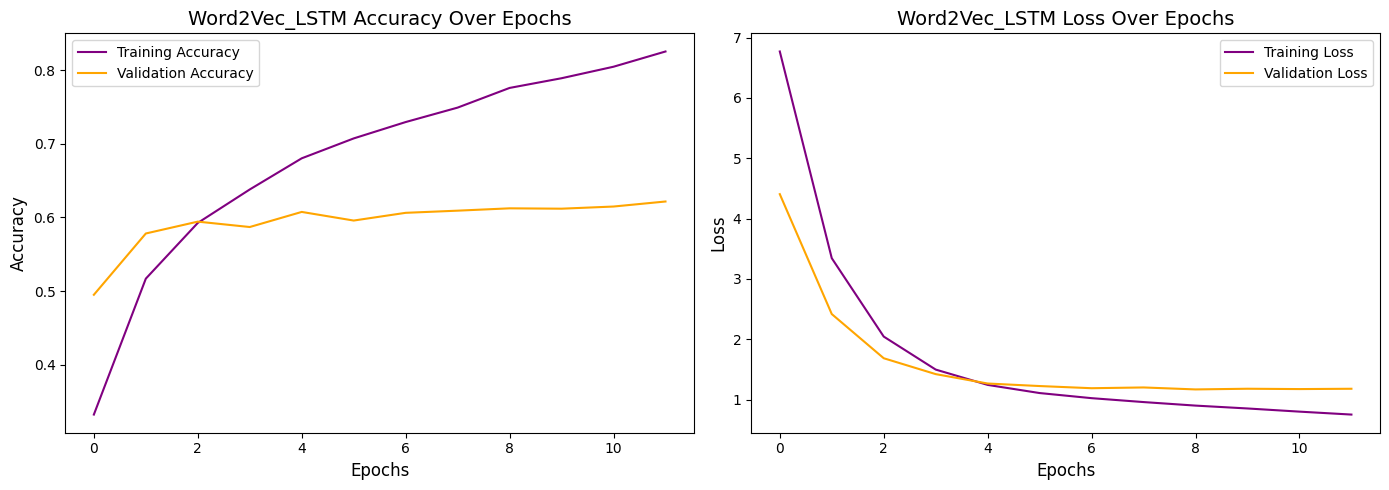

In [ ]:
print("\nTraining Word2Vec LSTM Model...")
word2vec_history = train_network(word2vec_lstm_model, train_padded, train_labels_encoded, test_padded, test_labels_encoded, "Word2Vec_LSTM")

In [ ]:
# Evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_test_classes, y_pred_classes)
    print(f"\n{model_name} Evaluation:")
    print("Accuracy:", acc)
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=['1', '2', '3', '4', '5']))

    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1', '2', '3', '4', '5'], yticklabels=['1', '2', '3', '4', '5'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()

    return acc

129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

RNN Evaluation:
Accuracy: 0.5006099048548427

Classification Report:
              precision    recall  f1-score   support

           1       0.40      0.52      0.45       284
           2       0.33      0.26      0.29       359
           3       0.27      0.19      0.22       437
           4       0.42      0.23      0.30      1208
           5       0.58      0.80      0.68      1811

    accuracy                           0.50      4099
   macro avg       0.40      0.40      0.39      4099
weighted avg       0.47      0.50      0.47      4099



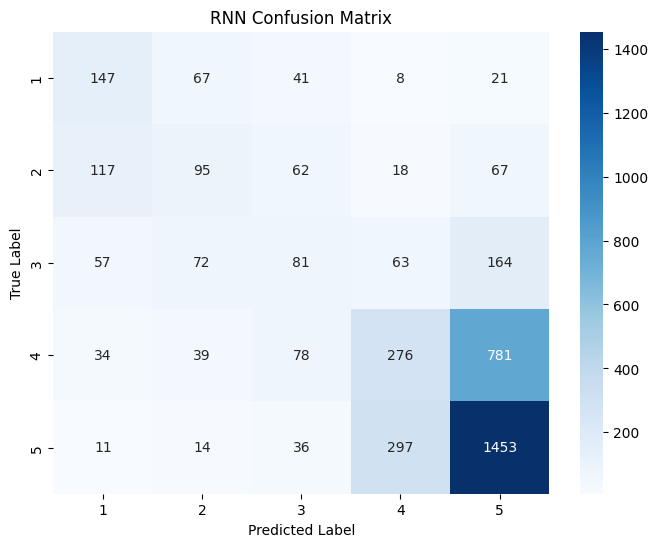

In [ ]:
rnn_accuracy = evaluate_model(rnn_model, test_padded, test_labels_encoded, "RNN")

129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

LSTM Evaluation:
Accuracy: 0.5659917052939741

Classification Report:
              precision    recall  f1-score   support

           1       0.54      0.71      0.62       284
           2       0.36      0.21      0.26       359
           3       0.31      0.40      0.35       437
           4       0.51      0.34      0.41      1208
           5       0.68      0.80      0.74      1811

    accuracy                           0.57      4099
   macro avg       0.48      0.49      0.47      4099
weighted avg       0.55      0.57      0.55      4099



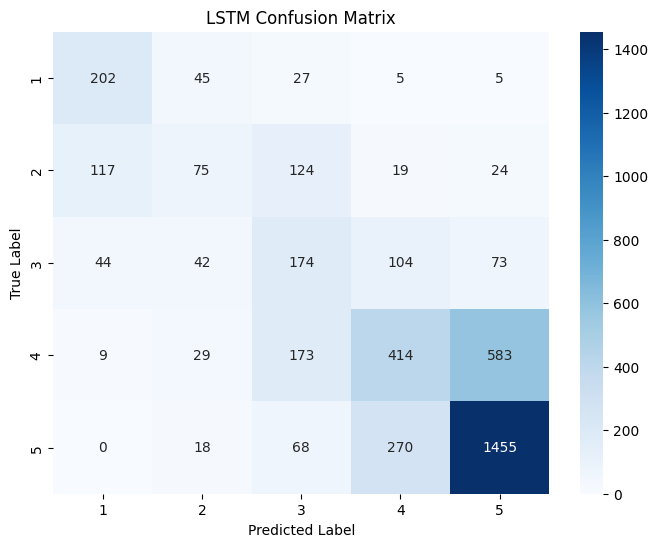

In [ ]:
acc2 = evaluate_model(lstm_model, test_padded, test_labels_encoded, "LSTM")

129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step

Word2Vec_LSTM Evaluation:
Accuracy: 0.6123444742620151

Classification Report:
              precision    recall  f1-score   support

           1       0.70      0.65      0.68       284
           2       0.46      0.50      0.48       359
           3       0.33      0.47      0.39       437
           4       0.54      0.42      0.47      1208
           5       0.76      0.79      0.77      1811

    accuracy                           0.61      4099
   macro avg       0.56      0.57      0.56      4099
weighted avg       0.62      0.61      0.61      4099



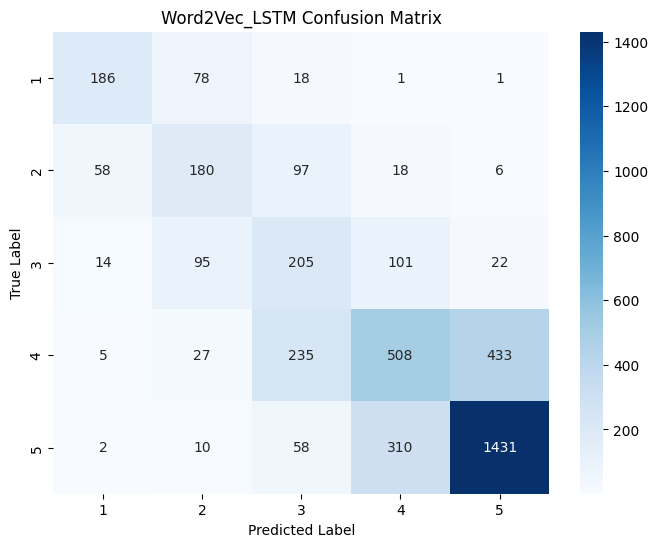

In [ ]:
acc3 = evaluate_model(word2vec_lstm_model, test_padded, test_labels_encoded, "Word2Vec_LSTM")

<ipython-input-45-c2ce88ae599a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='Set2')


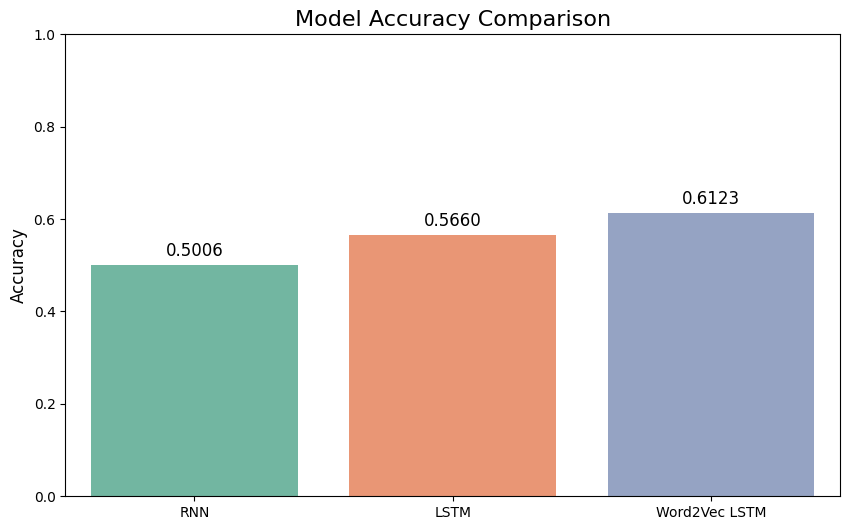

In [ ]:
plt.figure(figsize=(10, 6))
accuracies = [rnn_accuracy, acc2, acc3]
models = ['RNN', 'LSTM', 'Word2Vec LSTM']
sns.barplot(x=models, y=accuracies, palette='Set2')
plt.title('Model Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)
plt.savefig('accuracy_comparison.png')
plt.show()

In [ ]:
# Gradio interface
def predict_hotel_rating(review_text, selected_model):
    if not review_text.strip():
        return "Please provide a review text."

    processed_text = clean_review_text(review_text)
    seq = text_tokenizer.texts_to_sequences([processed_text])
    padded_seq = pad_sequences(seq, maxlen=padding_length, padding='post', truncating='post')

    model_map = {
        "RNN": rnn_model,
        "LSTM": lstm_model,
        "Word2Vec LSTM": word2vec_lstm_model
    }

    if selected_model not in model_map:
        return "Invalid model selection."

    model = model_map[selected_model]
    pred = model.predict(padded_seq, verbose=0)[0]
    pred_rating = np.argmax(pred) + 1
    confidence_score = np.max(pred)

    return f"Predicted Rating: {pred_rating}\nConfidence Score: {confidence_score:.4f}"

In [ ]:
with gr.Blocks(theme=gr.themes.Default()) as interface:
    gr.Markdown("## Hotel Review Sentiment Analysis")
    gr.Markdown("Input a hotel review and choose a model to predict its rating (1-5).")

    with gr.Row():
        review_box = gr.Textbox(label="Enter Review", placeholder="e.g., The staff was incredibly helpful!", lines=4)
    with gr.Row():
        model_selector = gr.Dropdown(choices=["RNN", "LSTM", "Word2Vec LSTM"], label="Choose Model", value="Word2Vec LSTM")

    predict_btn = gr.Button("Get Rating Prediction")
    result_box = gr.Textbox(label="Prediction Output", placeholder="Results will display here...")

    predict_btn.click(fn=predict_hotel_rating, inputs=[review_box, model_selector], outputs=result_box)

interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://53608b0632fdce8a7b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [2]:
!pip install --upgrade \
  pandas \
  numpy \
  matplotlib \
  seaborn \
  wordcloud \
  scikit-learn \
  tensorflow \
  keras \
  gensim \
  nltk \
  contractions \
  gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import os
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import gradio as gr

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# GloVe embeddings
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import gensim.downloader as api

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Cell 2: Load & Clean Data
df = pd.read_csv('/content/drive/MyDrive/AL and ML/Hotel_Reviews.csv')[['Review', 'Rating']].dropna()
print("Rating Distribution:\n", df['Rating'].value_counts().sort_index())

Rating Distribution:
 Rating
1    1421
2    1793
3    2184
4    6039
5    9054
Name: count, dtype: int64


In [4]:
# Convert ratings to binary sentiment (1-2: bad(0), 4-5: good(1), remove 3)
df = df[df['Rating'] != 3]
df['Sentiment'] = df['Rating'].apply(lambda x: 0 if x <= 2 else 1)

In [5]:
# Check class distribution
print("Class Distribution:")
print(df['Sentiment'].value_counts())

Class Distribution:
Sentiment
1    15093
0     3214
Name: count, dtype: int64


In [6]:
df.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1
5,love monaco staff husband stayed hotel crazy w...,5,1


In [37]:
df.isnull().any()

,0
Review,False
Rating,False
Sentiment,False


In [7]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Expand contractions
    text = contractions.fix(text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|\#\w+', '', text)

    # Remove numbers and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

In [8]:
# Split into train and test
X = df['Review']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Clean text
X_train_clean = X_train.apply(clean_text)
X_test_clean = X_test.apply(clean_text)

Generating word cloud for cleaned training data...


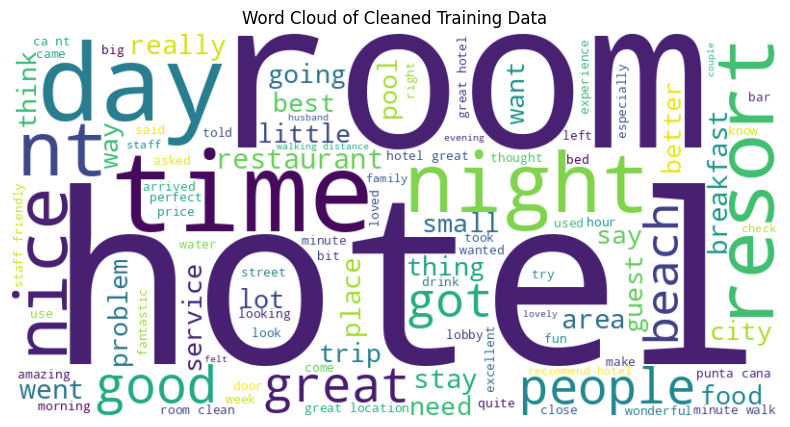

In [38]:
print("Generating word cloud for cleaned training data...")
all_text = ' '.join(X_train_clean)
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, random_state=42).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Training Data')
plt.show()

Generating bar plot of most frequent words...


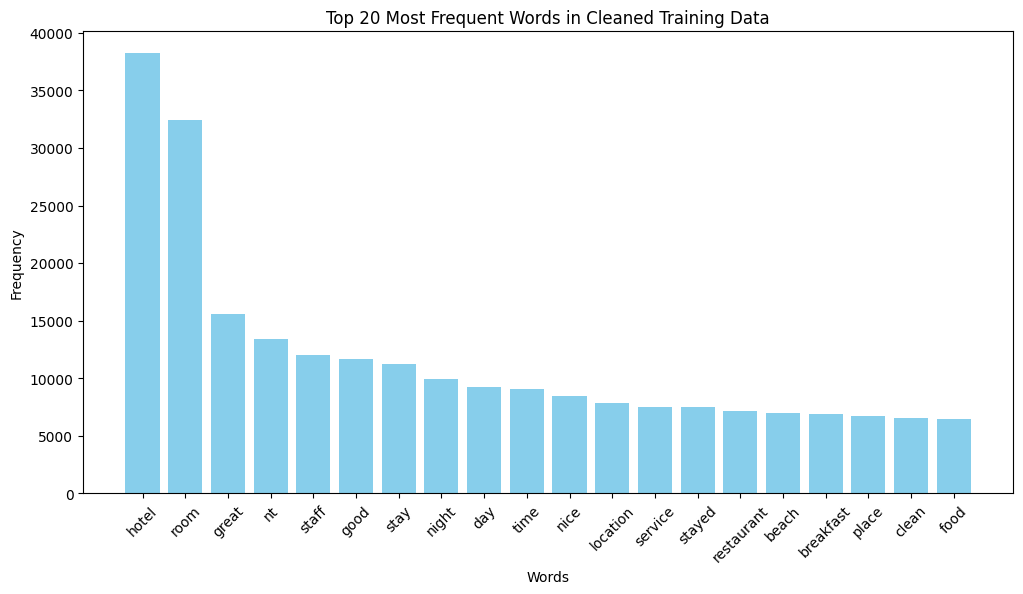

In [39]:
print("Generating bar plot of most frequent words...")
words = all_text.split()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)  # Top 20 words
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 20 Most Frequent Words in Cleaned Training Data')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Tokenization
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_clean)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_clean)
X_test_seq = tokenizer.texts_to_sequences(X_test_clean)

# Calculate sequence lengths to determine padding length (95th percentile)
train_seq_lengths = [len(seq) for seq in X_train_seq]
percentile_95 = np.percentile(train_seq_lengths, 95)
max_len = int(percentile_95)
print(f"Using sequence length of {max_len} (95th percentile)")

# Pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Validate data shapes
print(f"X_train_pad shape: {X_train_pad.shape}, y_train shape: {y_train.shape}")
print(f"X_test_pad shape: {X_test_pad.shape}, y_test shape: {y_test.shape}")
print("Test class distribution:", np.unique(y_test, return_counts=True))

Using sequence length of 254 (95th percentile)
X_train_pad shape: (14645, 254), y_train shape: (14645,)
X_test_pad shape: (3662, 254), y_test shape: (3662,)
Test class distribution: (array([0, 1]), array([ 643, 3019]))


In [10]:
# Apply SMOTE to the padded sequences
print("\nBefore SMOTE class distribution:", np.unique(y_train, return_counts=True))


Before SMOTE class distribution: (array([0, 1]), array([ 2571, 12074]))


In [11]:
# Reshape for SMOTE (temporarily flatten the sequences)
n_samples, n_timesteps = X_train_pad.shape
X_train_flat = X_train_pad.reshape(n_samples, -1)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled_flat, y_train_resampled = smote.fit_resample(X_train_flat, y_train)

# Reshape back to original dimensions
X_train_resampled = X_train_resampled_flat.reshape(-1, n_timesteps)

print("After SMOTE class distribution:", np.unique(y_train_resampled, return_counts=True))

After SMOTE class distribution: (array([0, 1]), array([12074, 12074]))


In [15]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weight_dict)

Class weights: {0: 1.0, 1: 1.0}


In [16]:
# Model 1: Simple RNN
embedding_dim = 128

# Model 1: Simple RNN (Trainable Embedding)
model1 = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid activation, no extra Dense layer
])

model1.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
# Model 2: LSTM (Trainable Embedding)
model2 = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid activation, no extra Dense layer
])

model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
def train_model(model, X_train, y_train, X_val, y_val, model_name, epochs=30):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    try:
        print(f"Training {model_name} with input shapes: X_train={X_train.shape}, y_train={y_train.shape}, X_val={X_val.shape}, y_val={y_val.shape}")
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=64,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, reduce_lr],
            class_weight=class_weight_dict,
            verbose=1
        )

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

        return history
    except Exception as e:
        print(f"Error training {model_name}: {str(e)}")
        return None

Training Model 1 (SimpleRNN)...
Training SimpleRNN with input shapes: X_train=(24148, 254), y_train=(24148,), X_val=(3662, 254), y_val=(3662,)
Epoch 1/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5937 - loss: 0.6744 - val_accuracy: 0.1942 - val_loss: 0.7115 - learning_rate: 0.0010
Epoch 2/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5354 - loss: 0.6870 - val_accuracy: 0.7430 - val_loss: 0.5671 - learning_rate: 0.0010
Epoch 3/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7368 - loss: 0.5626 - val_accuracy: 0.7652 - val_loss: 0.5266 - learning_rate: 0.0010
Epoch 4/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8206 - loss: 0.4575 - val_accuracy: 0.6578 - val_loss: 0.6649 - learning_rate: 0.0010
Epoch 5/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8090 - loss: 0.4652 - val_accuracy: 0.7944 - val_loss: 0.4812 - learning_rate: 0.0010
Epoch 6/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8423 - loss: 0.4102 - va

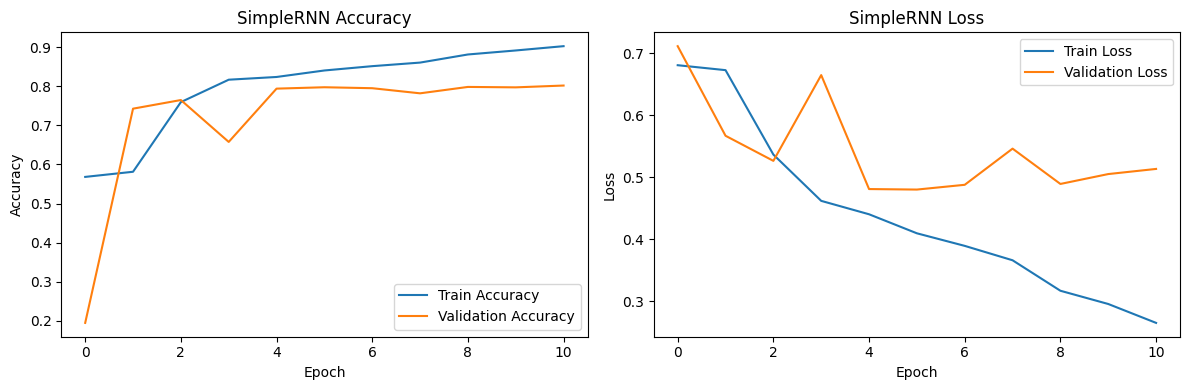

In [22]:
# Train models
print("Training Model 1 (SimpleRNN)...")
history1 = train_model(model1, X_train_resampled, y_train_resampled, X_test_pad, y_test, "SimpleRNN")


Training Model 2 (LSTM)...
Training LSTM with input shapes: X_train=(24148, 254), y_train=(24148,), X_val=(3662, 254), y_val=(3662,)
Epoch 1/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5001 - loss: 0.6939 - val_accuracy: 0.7941 - val_loss: 0.6765 - learning_rate: 0.0010
Epoch 2/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5049 - loss: 0.6942 - val_accuracy: 0.8105 - val_loss: 0.6681 - learning_rate: 0.0010
Epoch 3/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5310 - loss: 0.6836 - val_accuracy: 0.7758 - val_loss: 0.4758 - learning_rate: 0.0010
Epoch 4/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8735 - loss: 0.3441 - val_accuracy: 0.8646 - val_loss: 0.3114 - learning_rate: 0.0010
Epoch 5/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9325 - loss: 0.2103 - val_accuracy: 0.9044 - val_loss: 0.2449 - learning_rate: 0.0010
Epoch 6/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9699 - loss: 0.1059 - val_accu

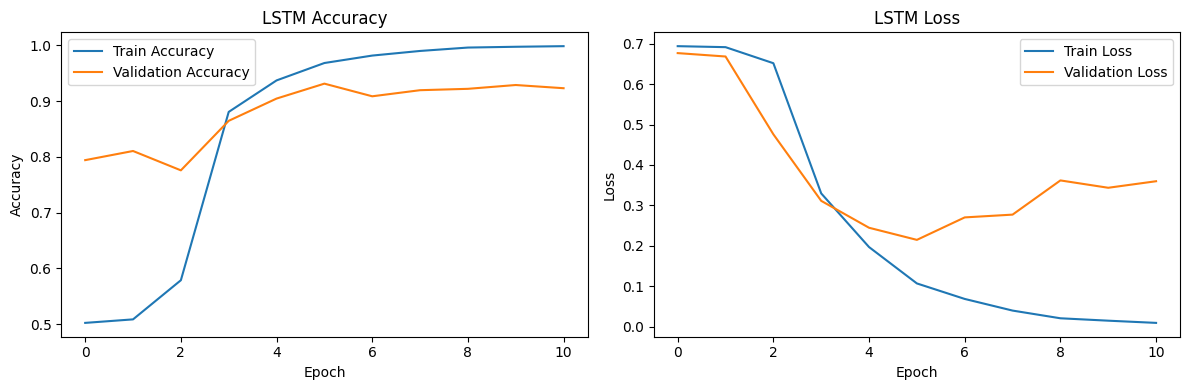

In [23]:
print("\nTraining Model 2 (LSTM)...")
history2 = train_model(model2, X_train_resampled, y_train_resampled, X_test_pad, y_test, "LSTM")

In [24]:
# Load Pre-trained GloVe Embeddings (300-dimensional) for Model 3
print("Loading GloVe embeddings for Model 3...")
try:
    embedding_model = api.load('glove-wiki-gigaword-300')
    embedding_dim = 300
except Exception as e:
    print(f"Error loading GloVe embeddings: {str(e)}")
    exit()

Loading GloVe embeddings for Model 3...


In [25]:
#  Create embedding matrix for Model 3
vocab_size = min(max_words, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in embedding_model:
        embedding_matrix[i] = embedding_model[word]

In [26]:
# Model 3: LSTM with GloVe Embeddings
model3 = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=True),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid activation, no extra Dense layer
])

model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training Model 3 (LSTM with GloVe)...
Training LSTM with GloVe with input shapes: X_train=(24148, 254), y_train=(24148,), X_val=(3662, 254), y_val=(3662,)
Epoch 1/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5094 - loss: 0.6920 - val_accuracy: 0.8037 - val_loss: 0.6886 - learning_rate: 0.0010
Epoch 2/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5150 - loss: 0.6894 - val_accuracy: 0.8184 - val_loss: 0.6752 - learning_rate: 0.0010
Epoch 3/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5612 - loss: 0.6561 - val_accuracy: 0.8727 - val_loss: 0.3760 - learning_rate: 0.0010
Epoch 4/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8935 - loss: 0.3294 - val_accuracy: 0.8935 - val_loss: 0.3036 - learning_rate: 0.0010
Epoch 5/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9492 - loss: 0.1822 - val_accuracy: 0.8979 - val_loss: 0.2643 - learning_rate: 0.0010
Epoch 6/30
378/378 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9662 - loss

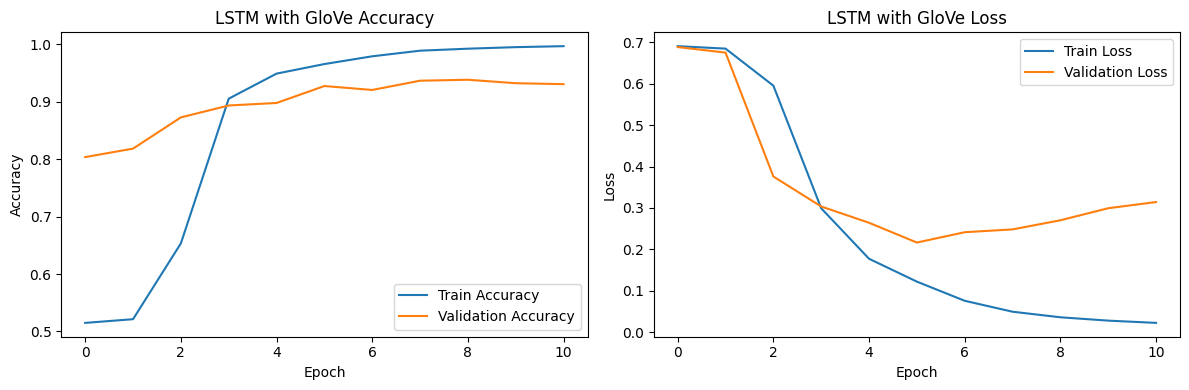

In [27]:
print("\nTraining Model 3 (LSTM with GloVe)...")
history3 = train_model(model3, X_train_resampled, y_train_resampled, X_test_pad, y_test, "LSTM with GloVe")

In [28]:
#  Evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print(f"\n{model_name} Evaluation:")
    acc = accuracy_score(y_test, y_pred) # Calculate accuracy
    print("Accuracy:", acc)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return acc # Return the accuracy

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

SimpleRNN Evaluation:
Accuracy: 0.7979246313489896

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.76      0.57       643
           1       0.94      0.81      0.87      3019

    accuracy                           0.80      3662
   macro avg       0.70      0.78      0.72      3662
weighted avg       0.86      0.80      0.82      3662



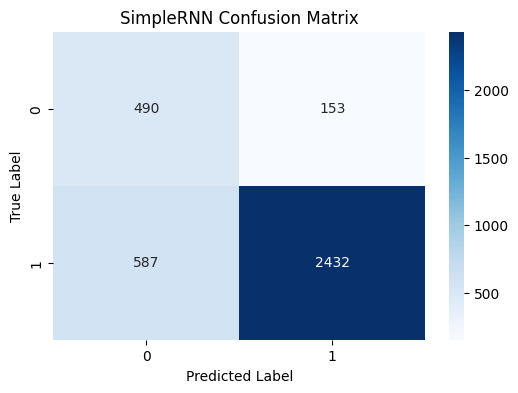

In [29]:
# Evaluate models and collect accuracies
acc1 = evaluate_model(model1, X_test_pad, y_test, "SimpleRNN")

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

LSTM Evaluation:
Accuracy: 0.931185144729656

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.76      0.79       643
           1       0.95      0.97      0.96      3019

    accuracy                           0.93      3662
   macro avg       0.89      0.86      0.88      3662
weighted avg       0.93      0.93      0.93      3662



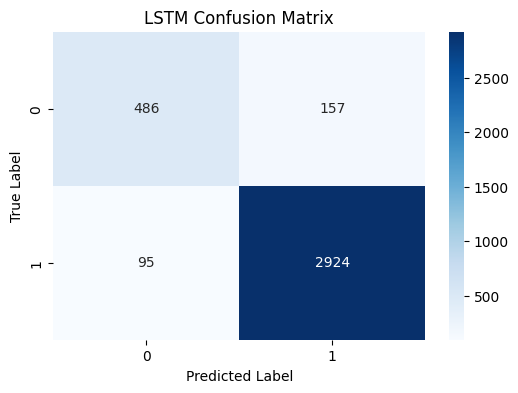

In [30]:
acc2 = evaluate_model(model2, X_test_pad, y_test, "LSTM")

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

LSTM with GloVe Evaluation:
Accuracy: 0.9273620972146368

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       643
           1       0.96      0.95      0.96      3019

    accuracy                           0.93      3662
   macro avg       0.87      0.89      0.88      3662
weighted avg       0.93      0.93      0.93      3662



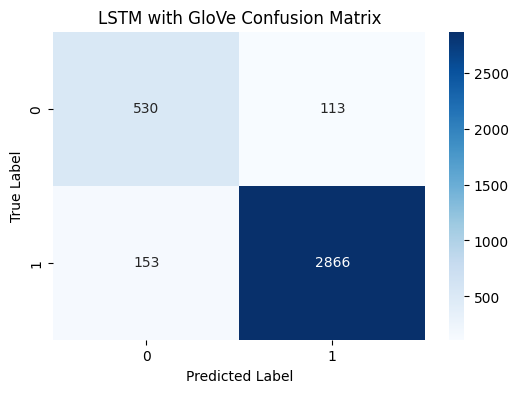

In [31]:
acc3 = evaluate_model(model3, X_test_pad, y_test, "LSTM with GloVe")


Accuracies: {'SimpleRNN': 0.7979246313489896, 'LSTM': 0.931185144729656, 'LSTM with GloVe': 0.9273620972146368}


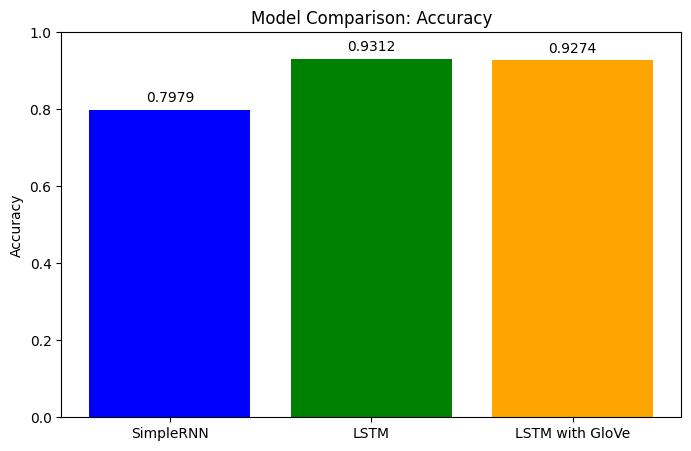

In [32]:
# Debug: Print accuracies to check for None values
print("\nAccuracies:", {"SimpleRNN": acc1, "LSTM": acc2, "LSTM with GloVe": acc3})

# Compare model performances
models = ['SimpleRNN', 'LSTM', 'LSTM with GloVe']
accuracies = [acc1, acc2, acc3]

# Handle None values in accuracies
valid_accuracies = [acc if acc is not None else 0.0 for acc in accuracies]
valid_models = [m for m, acc in zip(models, accuracies) if acc is not None]

if not valid_accuracies:
    print("Error: No valid accuracies to plot. Check model training and evaluation.")
else:
    plt.figure(figsize=(8, 5))
    plt.bar(valid_models, valid_accuracies, color=['blue', 'green', 'orange'])
    plt.title('Model Comparison: Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for i, v in enumerate(valid_accuracies):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
    plt.show()

In [33]:
# Prediction function
def predict_sentiment(review, model_name):
    if not review.strip():
        return "Please enter a review."

    # Clean and preprocess the input review
    cleaned_review = clean_text(review)
    sequence = tokenizer.texts_to_sequences([cleaned_review])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # Select model
    model_dict = {
        "SimpleRNN": model1,
        "LSTM": model2,
        "LSTM with GloVe": model3
    }

    if model_name not in model_dict:
        return "Invalid model selected."

    model = model_dict[model_name]

    # Predict
    prediction = model.predict(padded_sequence, verbose=0)[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return f"Sentiment: {sentiment}\nConfidence: {confidence:.4f}"

In [34]:
# Gradio interface
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("## Hotel Review Sentiment Prediction")
    gr.Markdown("Enter a hotel review and select a model to predict whether the sentiment is Positive or Negative.")

    with gr.Row():
        review_input = gr.Textbox(
            label="Hotel Review",
            placeholder="e.g., The hotel was amazing with great service!",
            lines=3
        )

    with gr.Row():
        model_choice = gr.Dropdown(
            choices=["SimpleRNN", "LSTM", "LSTM with GloVe"],
            label="Select Model",
            value="LSTM"
        )

    predict_button = gr.Button("Predict Sentiment")
    output = gr.Textbox(label="Prediction Result", placeholder="Prediction will appear here...")

    predict_button.click(
        fn=predict_sentiment,
        inputs=[review_input, model_choice],
        outputs=output
    )

In [35]:
demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2e6306a049046e3c06.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
